# Urban Tourism: City Recommender System.

## IBM Data Science Professional: Capstone Project
This notebook is made to support the IBM Data Science Professional Capstone Project. A link to the GitHub page including code will be provided at the end of this notebook. Please note that this project is purely for educational purposes. I take no credits or ownership of the data used in this project.

## 1. Introduction
Travel is booming. We all know that one person posting new photos of their weekend-travels on daily basis on their polished Instagram-account, posing with their all-year tan and Lonely Planet guides. Good food, great sights and views, and a break away from the same-old-same-old, what is not to like?

Indeed, international tourism has exploded since the end of the Second World War. The World Tourism (UNTWO) reports only 25 million people in 1950 as international tourists, this increased to 166 million people in 1970, 435 million in 1990, and an impressive 1.4 billion people in 2018. Moreover, digitization of the tourism & hospitality sector creates an increased accessibility of to travel. Platform such as Booking.com and AirBnB have revolutionized the travelling business by increasing visibility and accessibility for overnight stays in foreign and domestic places. Moreover, the travel booking platform Expedia had a contest to develop personalized recommendations for travel with personalized pricing, using purchase history and hotel characteristics. A key strength of such platforms is the ability to offer personalized recommendations using customer data to improve customer experience. However, currently, little information is available on travel recommendation systems based on a customer preference in their home city.  

As such, I propose that travel destinations can be done based on customer behaviour in their own city. By building a profile of the customer based on the types of venues they visit, and comparing that to the types venues a city offers, it is possible to recommend ideal destinations. This would increase traveler satisfaction, and help travelers pick their ideal location for an Instagram post.

We can frame the question more specifically as: _"Can we give recommendations on cities to persons, based on user preferences for venues defined by the user?"_

## 2. Data Descriptions and Wrangling, and Notebook Preparations

For this project we use the following data: 
    - Geolocation city data (Cities with Population > 15000 p.): https://download.geonames.org/export/dump/cities15000.zip
    - Venue location / rating data: https://developer.foursquare.com/

### 2.1 Package Importing & API Credentials
In this section important packages are imported into the notebook. Moreover, credentials from the Foursquare API Service are defined.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [659]:
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [137]:
# Define Foursquare Credentials and Version

CLIENT_ID = '3OIXLD5DY2KFRNNBAZZODETQKIEHH1EY5E53BOUAJHWNVI0B' # your Foursquare ID
CLIENT_SECRET = 'RY3RBMRUHJA0ASNLDGHC4J2LCWJFJKZU45UEGPNFE42M0YS2' # your Foursquare Secret
VERSION = '20161225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3OIXLD5DY2KFRNNBAZZODETQKIEHH1EY5E53BOUAJHWNVI0B
CLIENT_SECRET:RY3RBMRUHJA0ASNLDGHC4J2LCWJFJKZU45UEGPNFE42M0YS2


### 2.2 Data Importing
In this section we read the main dataframes into the Notebook.

In [38]:
#Read the cities file with cities > 15000p.
fileread= r'C:\Users\320042528\Desktop\projects\IBM-cap\cities15000\cities15000.txt' #defines file location
headers = ['geonameid', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 
            'feature_class', 'feature_code', 'country_code', 'cc2', 'ad1c', 'ad2c', 'ad3c', 'ad4c',
           'population', 'elevation', 'dem', 'timezone', 'modif_date'] #defines the column names.
df_cities = pd.read_csv(fileread, delimiter='\t', names=headers) #read the csv.
df_cities.head() #check the dataframe

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,ad1c,ad2c,ad3c,ad4c,population,elevation,dem,timezone,modif_date
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,NaN,08,NaN,NaN,NaN,15853,NaN,1033,Europe/Andorra,2008-10-15
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109,P,PPLC,AD,NaN,07,NaN,NaN,NaN,20430,NaN,1037,Europe/Andorra,2010-05-30
2,290594,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",25.56473,55.55517,P,PPLA,AE,NaN,07,NaN,NaN,NaN,62747,NaN,2,Asia/Dubai,2019-10-24
3,291074,Ras Al Khaimah City,Ras Al Khaimah City,"Julfa,Khaimah,RAK City,RKT,Ra's al Khaymah,Ra'...",25.78953,55.94320,P,PPLA,AE,NaN,05,NaN,NaN,NaN,351943,NaN,2,Asia/Dubai,2019-09-09
4,291580,Zayed City,Zayed City,"Bid' Zayed,Bid’ Zayed,Madinat Za'id,Madinat Za...",23.65416,53.70522,P,PPL,AE,NaN,01,103,NaN,NaN,63482,NaN,124,Asia/Dubai,2019-10-24


We can already identify some columns that we don't want to be using. For our analysis the following data is not relevant: 
- alternatenames, 
- feature class, 
- feature code, 
- country code, 
- cc2, ad1c, ad2c, ad3c, ad4c
- 'modif_date'

In [39]:
# define columns we want to drop as a list.
dropcols =  ['alternatenames','feature_class', 'feature_code', 'country_code', 'cc2', 'ad1c', 'ad2c', 'ad3c', 'ad4c', 'modif_date']
df_cities.drop(dropcols, axis=1, inplace=True) #drops the defined columns
df_cities.head() 

,geonameid,name,asciiname,latitude,longitude,population,elevation,dem,timezone
0,3040051,les Escaldes,les Escaldes,42.50729,1.53414,15853,NaN,1033,Europe/Andorra
1,3041563,Andorra la Vella,Andorra la Vella,42.50779,1.52109,20430,NaN,1037,Europe/Andorra
2,290594,Umm Al Quwain City,Umm Al Quwain City,25.56473,55.55517,62747,NaN,2,Asia/Dubai
3,291074,Ras Al Khaimah City,Ras Al Khaimah City,25.78953,55.94320,351943,NaN,2,Asia/Dubai
4,291580,Zayed City,Zayed City,23.65416,53.70522,63482,NaN,124,Asia/Dubai


Let us check some characteristics of our cities data. The following snippet shows we have 24347 cities in our dataframe.

In [40]:
df_cities.shape #shows the shape of our data frame (rows, columns)

(24347, 9)

Since we are relatively limited in the number of calls we can do to the Foursquare API - we will focus on a subset of this cities data. Let us see if we can focus on cities within Europe. To estimate which cities lie in Europe, we add an additional column based on the timezone column, and see if it contains europe.

In [41]:
df_cities['timezone'].value_counts()

Asia/Kolkata                      2465
America/New_York                  1409
Europe/Berlin                     1067
America/Chicago                    892
Asia/Shanghai                      788
Europe/London                      768
America/Sao_Paulo                  747
Asia/Tokyo                         739
Europe/Moscow                      678
Europe/Paris                       640
Europe/Rome                        603
America/Los_Angeles                593
Europe/Madrid                      580
America/Mexico_City                481
Asia/Manila                        449
Europe/Istanbul                    392
Europe/Warsaw                      333
Asia/Karachi                       316
Asia/Jakarta                       298
Africa/Algiers                     247
Africa/Lagos                       244
Europe/Amsterdam                   225
America/Bogota                     223
Asia/Bangkok                       220
Europe/Kiev                        204
Asia/Tehran              

In [42]:
#saves the continent of the timezone before the seperator in the timezone column, in a new column called continent
df_cities['continent'] = df_cities['timezone'].str.split("\/", n = 1, expand = True)[0]
cities_inEU = df_cities['continent'] =='Europe'
df_citiesEU = df_cities[cities_inEU]
df_citiesEU.head()

,geonameid,name,asciiname,latitude,longitude,population,elevation,dem,timezone,continent
0,3040051,les Escaldes,les Escaldes,42.50729,1.53414,15853,NaN,1033,Europe/Andorra,Europe
1,3041563,Andorra la Vella,Andorra la Vella,42.50779,1.52109,20430,NaN,1037,Europe/Andorra,Europe
72,363243,Sarandë,Sarande,39.87534,20.00477,15147,NaN,170,Europe/Tirane,Europe
73,781988,Pogradec,Pogradec,40.90250,20.65250,61530,NaN,702,Europe/Tirane,Europe
74,782661,Kukës,Kukes,42.07694,20.42194,17832,NaN,351,Europe/Tirane,Europe


Let us see if this helped reducing number of rows by printing the shape of the dataframe again. (Rows x Colums). This shows us that we have 7271 cities left to work with! Indeed, a significant reduction.

In [93]:
df_citiesEU.shape #print the shape of our citiesEU dataframe (rows, columns)

(7271, 10)

Now, let us see the distribution of cities based on their population. We define some bins based on the maximum population we can find within Europe.

Text(0, 0.5, 'Frequency (# of cities)')

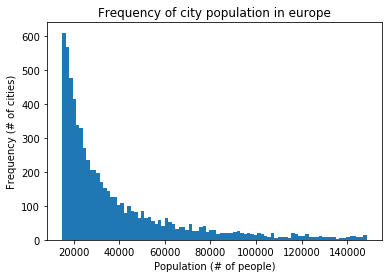

In [44]:
binmin = int(15000) #the downloaded data contained cities only with a population > 15000 people.
binmax = int(round(df_citiesEU['population'].max()/1000000)*1000000) #round up the maximum population to a nicely rounded number.
bins = np.arange(binmin, binmax/100, int(binmax/10000)) #create bins with stepsize based on the max. population.

plottitle = 'Frequency of city population in europe'
xlab = 'Population (# of people)'
ylab = 'Frequency (# of cities)'

plt.hist(df_citiesEU['population'], bins = bins)
plt.title(plottitle)
plt.xlabel(xlab)
plt.ylabel(ylab)

Note that this seems to be an exponential distribution. This can also be due to the arbitrary starting point of taking only cities with a population larger than 15.000 people. Nevertheless, from eyeballing this graph we see that the bulk of cities lies in the range of a populations smaller than 40.000 people. We are filtering for the top 1000 cities (based on population) within Europe to be able to properly hold to API call constraints

Moreover, to prepare the data for our model - will only keep the following columns for the city data: 

- ascii_name
- latitude
- longitude

In [315]:
N_top = 500
df_citiesEU_top = df_citiesEU.nlargest(N_top,['population'])

dropcols_mod = ['geonameid', 'name', 'population', 'elevation', 'dem', 'timezone', 'continent']
df_citiesEU_mod = df_citiesEU_top.copy() #drops the defined columns
df_citiesEU_mod.drop(dropcols_mod, axis=1, inplace=True)
df_citiesEU_mod.head()

df_citiesEU_testframe=df_citiesEU_mod.head(500).copy()
df_citiesEU_testframe.head()

,asciiname,latitude,longitude
19883,Istanbul,41.01384,28.94966
18008,Moscow,55.75222,37.61556
7840,London,51.50853,-0.12574
17837,Saint Petersburg,59.93863,30.31413
19791,Ankara,39.91987,32.85427


Next - we start calling the top 10 venues per city from the foursquare API based on the location (latitude / longitude) data from Geonames. The maximum supported radius from Foursquare to search in is 100 km, covering a total area of 30.000km^2. Plenty of cities are larger - However, for the sake of this exercise, we assume that the central area of a city and its venues are covered with this radius.

As such, the ease the burden of copy pasting the code when we need to look for venues in a city, we develop the following function based on the _explore_ feature of FourSquare:

In [289]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT, CLIENT_ID, CLIENT_SECRET, VERSION):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
             
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
      
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City_Latitude', 
                  'City_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

Now we store the data of this calls in a pandas dataframe, and check the results.

In [290]:
cities = df_citiesEU_testframe['asciiname']
lats = df_citiesEU_testframe['latitude']
longs = df_citiesEU_testframe['longitude']
rad = 50000 #m
LIM = 30 #number of venues recommended.

df_venEU = getNearbyVenues(names=cities, latitudes = lats, longitudes = longs, radius=rad, LIMIT = LIM, 
                           CLIENT_ID=CLIENT_ID, CLIENT_SECRET=CLIENT_SECRET, VERSION=VERSION)

#make a copy to use in case we screw up and cannot re-request the data.
df_venEU_copy = df_venEU.copy()

Istanbul
Moscow
London
Saint Petersburg
Ankara
Berlin
Madrid
Kyiv
Izmir
Rome
Paris
Bucharest
Minsk
Budapest
Hamburg
Warsaw
Vienna
Barcelona
Stockholm
Kharkiv
Bursa
Nizhniy Novgorod
Belgrade
Munich
Adana
Milan
Prague
Copenhagen
Sofia
Samara
Kazan
Rostov-na-Donu
Gaziantep
Dnipro
Donetsk
Dublin
Brussels
Volgograd
Odessa
Birmingham
Koeln
Naples
Konya
Turin
Liverpool
Saratov
Voronezh
Valencia
Zaporizhia
Marseille
Cankaya
Lodz
Antalya
Krakow
Riga
Amsterdam
Nottingham
Bagcilar
Lviv
Sevilla
Tol'yatti
Zagreb
Sarajevo
Sheffield
Zaragoza
Athens
Kryvyi Rih
Frankfurt am Main
Krasnodar
Palermo
Diyarbakir
Ulyanovsk
Chisinau
Wroclaw
Izhevsk
Bristol
Yaroslavl
Rotterdam
Essen
Kayseri
Glasgow
Stuttgart
Dortmund
UEskuedar
Genoa
Oslo
Bahcelievler
Umraniye
Duesseldorf
Goeteborg
Poznan
Malaga
Helsinki
Pristina
Bremen
Vilnius
Mersin
Esenler
Ryazan'
Lisbon
Lipetsk
Hannover
Eskisehir
Penza
Mykolayiv
Naberezhnyye Chelny
Leicester
Leipzig
Kalininskiy
Duisburg
Astrakhan
Nuernberg
Makhachkala
Dresden
Mariupol
Homye

KeyError: 'groups'

In [316]:
df_venEU= df_venEU_copy.copy()

Let us quickly explore the different type of venues, and the occurence of each type in general.

In [292]:
df_venEU['Venue_Category'].value_counts() #gives occurence of each venue category.

Park                    433
Café                    287
Coffee Shop             273
Hotel                   211
Plaza                   198
Restaurant              131
Bar                     125
Pub                     110
Historic Site           110
Pizza Place              94
Theater                  94
Ice Cream Shop           83
Gym / Fitness Center     82
Dessert Shop             79
Italian Restaurant       68
Bakery                   58
Spanish Restaurant       56
Bookstore                55
Cocktail Bar             53
History Museum           52
Scenic Lookout           49
Gym                      47
Beach                    45
Beer Bar                 43
Wine Bar                 41
Museum                   41
Burger Joint             39
Gastropub                37
Art Gallery              36
Pedestrian Plaza         35
                       ... 
Vacation Rental           1
Kokoreç Restaurant        1
Office                    1
Pool Hall                 1
Dumpling Restaurant 

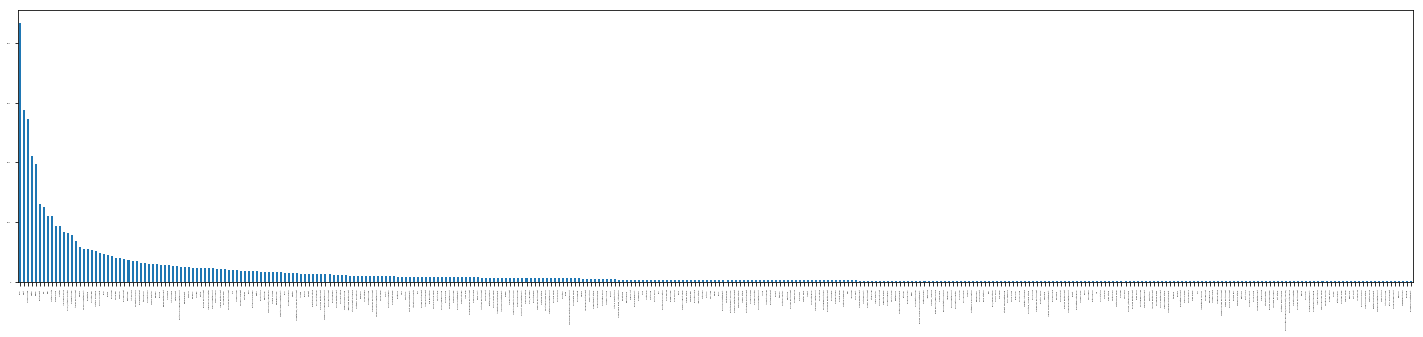

In [293]:
#plot the occurence of each venue category.
df_venEU['Venue_Category'].value_counts().plot(kind='bar', figsize=(25, 5), fontsize = 2)

We can note a lot of different unique categories. At the same time, we see venues with a similar purpose with different venue categories (i.e. a Whisky Bar and a Wine Bar will both serve the purpose of "Nightlife"). So we want to reduce the complexity by grouping these items together.

In [295]:
print("There are {} unique Venue Categories".format(df_venEU['Venue_Category'].nunique()))

There are 347 unique Venue Categories


To reduce the complexity of this data, we create a dataframe with a Category map based on the unique venue categories.
We distinguish the following venues:
- Restaurants
- Coffeehouses
- Nightlife
- Fastfood
- Art Venues
- Shopping Venues
- Educational Venues
- Parks/Recreational Venues
- Hotels & Airports
- Spa's
- Sport Venues
- Architectural Sights
- Transport Venues

We create a mapping based on keywords that we will look for in the Venue Categories. For example, Restaurants we distinguish based on keywords like "Restaurant, Steak, Pizza, Dinner, Bistro..." and so forth.

In [317]:
restaurants = 'Restaurant|Steak|Pizza|Diner|Dinner|Bistro|Eatery|Buffet|Food Court|Tavern' #taking all restaurant venues
df_venEU.loc[df_venEU['Venue_Category'].str.contains(restaurants, case=False), 'Venue_Category'] = 'restaurant'

coffeehouse = 'Coffee|Tea|Café|Cafe|Lunch|Breakfast|Sandwich|Bakery' #taking all coffee places and breakfast houses
df_venEU.loc[df_venEU['Venue_Category'].str.contains(coffeehouse, case=False), 'Venue_Category'] = 'coffeehouse'

nightlife = 'Night|Bar|Pub|Wine|Dance|Strip|Adult|Club|Speakeasy|Liquor|Brewery|Beer|Whiskey|Gin|Distillery' #nightlife activities
df_venEU.loc[df_venEU['Venue_Category'].str.contains(nightlife, case=False), 'Venue_Category'] = 'nightlife'

snacks_fastfood = 'Deli|Food|Burger|Burito|Cigkofte|Cream|Crepe|Creperie|Joint|Food Truck|Snack|Chips|Fries|Dessert|Donut|Waffle|Nutella|Joint' #taking all snack places
df_venEU.loc[df_venEU['Venue_Category'].str.contains(snacks_fastfood, case=False), 'Venue_Category'] = 'fastfood'

art_venue = 'Exhibit|Music|Gallery|Museum|Paintings|Monument|Church|Theater|Cinema|Sculpture|Concert|Art|Opera|Planetarium' #taking all snack places
df_venEU.loc[df_venEU['Venue_Category'].str.contains(art_venue, case=False), 'Venue_Category'] = 'art_venue'

shopping_venue = 'Arcade|Plaza|Shop|Clothes|Clothing|Mall|Shopping|Retail|Boutique|Store|Market|Butcher' #taking all shopping venues
df_venEU.loc[df_venEU['Venue_Category'].str.contains(shopping_venue, case=False), 'Venue_Category'] = 'shopping_venue'

edu = 'Kid|Nursery|Playground|Student|School|College|University|Cultural Center' #educational facilities
df_venEU.loc[df_venEU['Venue_Category'].str.contains(edu, case=False), 'Venue_Category'] = 'edu'

scenic = 'Beach|Pier|Lake|Nature|Scenic|Lookout|Outdoors|Vineyard|Bay|Island|Forest|Mountain|Canal|Lighthouse|River|Harbor' #scenic views
df_venEU.loc[df_venEU['Venue_Category'].str.contains(scenic, case=False), 'Venue_Category'] = 'scenic'

park = 'Zoo|Aquarium|Garden|Park|Recreation|Waterfront|Hill|Camp|Fair' #parks and recreational areas
df_venEU.loc[df_venEU['Venue_Category'].str.contains(park, case=False), 'Venue_Category'] = 'park'

hotels_airports = 'Motel|Hotel|Airport|Stay|Bed|Bnb|Hostel|Inn|Lounge' #hotels ans airports
df_venEU.loc[df_venEU['Venue_Category'].str.contains(hotels_airports, case=False), 'Venue_Category'] = 'hotels_airports'

spa_relaxation = 'Salon|Barber|Spa|Massage|Hair|Nail|Tanning|Resort|Bath House' #relaxation facilities
df_venEU.loc[df_venEU['Venue_Category'].str.contains(spa_relaxation, case=False), 'Venue_Category'] = 'spa_relaxation'

sport_venue = 'Dojo|Skating|Hockey|Golf|Bowling|Sport|Fitness|Yoga|Gym|Martial|Health|Pool|Sport|Tennis|Surf|Ski|Trail|Hike|Climbing|Stadium|Football|Basketball|Soccer' #sport facilities and stadia
df_venEU.loc[df_venEU['Venue_Category'].str.contains(sport_venue, case=False), 'Venue_Category'] = 'sport_venue'

architecture = 'Mosque|Church|Temple|Synagoge|Bridge|City Hall|Shrine|Palace|Castle|Fountain|Monastery|Town Hall|Historic' #architectural sights
df_venEU.loc[df_venEU['Venue_Category'].str.contains(architecture, case=False), 'Venue_Category'] = 'architecture'

transport = 'Train|Metro|Bus|Tram|Boat|Ferry|Bike|Bicycle|Rental Car' #transportation facilities, publix and private
df_venEU.loc[df_venEU['Venue_Category'].str.contains(transport, case=False), 'Venue_Category'] = 'transport'

Now that we've defined our category types based on clusters, we will group all other categories as "other". Note that there can of course be mislabeling due to the category name not being included in one of the keywords above at an appropriate venue type. However, for the sake of this exercise, we will assume here that this mapping sufficiently covers the different categories.

In [318]:
ven_type = ['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport']
df_venEU.loc[~df_venEU['Venue_Category'].isin(ven_type),'Venue_Category'] = 'Other'

In [319]:
df_venEU.head(20)

,City,City_Latitude,City_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Istanbul,41.01384,28.94966,Karadeniz Pide ve Güveç Köfte,41.017339,28.958249,restaurant
1,Istanbul,41.01384,28.94966,Nuruosmaniye Camii,41.010151,28.970701,architecture
2,Istanbul,41.01384,28.94966,Day Day Pastanesi,41.009440,28.968023,coffeehouse
3,Istanbul,41.01384,28.94966,SALT Galata,41.023853,28.973492,art_venue
4,Istanbul,41.01384,28.94966,Galata Kulesi,41.025641,28.974056,architecture
5,Istanbul,41.01384,28.94966,Edirnekapı Mihrimah Sultan Camii,41.029312,28.935778,architecture
6,Istanbul,41.01384,28.94966,GALATA MODA SHOP,41.024880,28.974906,shopping_venue
7,Istanbul,41.01384,28.94966,Dükkan Galata,41.025881,28.975390,coffeehouse
8,Istanbul,41.01384,28.94966,Ayasofya,41.008145,28.978724,art_venue
9,Istanbul,41.01384,28.94966,Sultan Ahmet Camii,41.006163,28.977064,architecture


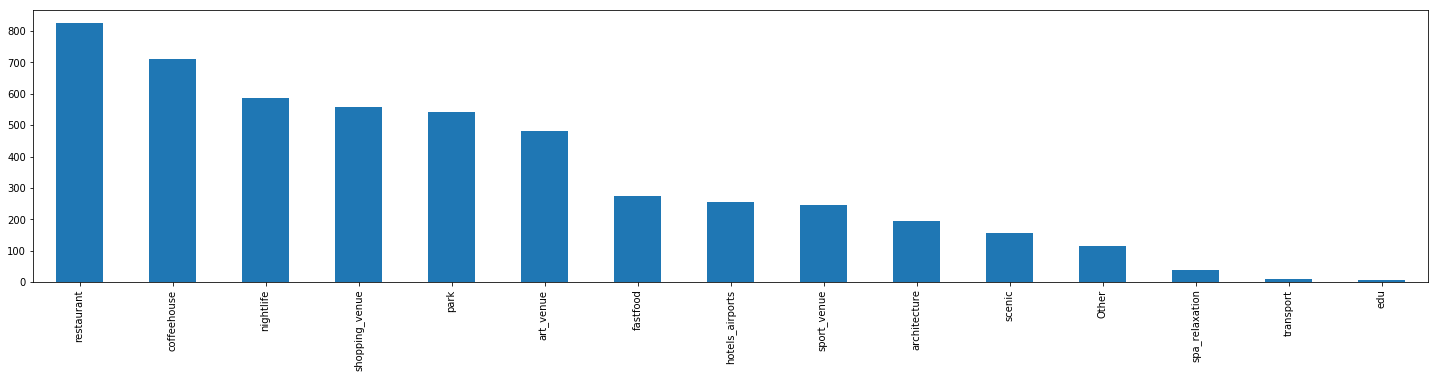

In [320]:
#plot the occurence of each venue category.
df_venEU['Venue_Category'].value_counts().plot(kind='bar', figsize=(25, 5), fontsize = 10)

### 2.3 Data Preparation for Modeling

Now, we apply "one-hot encoding" to the the dataframe and merge that dataframe to the individual cities. The shape indicates that one-hot encoding went smoothly, as it has the same number of rows as our cities _df_venEU_ dataframe.

In [300]:
onehot = pd.get_dummies(df_venEU.Venue_Category) #one hot encoding.
onehot.head()

,Other,architecture,art_venue,coffeehouse,edu,fastfood,hotels_airports,nightlife,park,restaurant,scenic,shopping_venue,spa_relaxation,sport_venue,transport
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [301]:
onehot.shape #check shape of the onehot encoded frame (rows, columns)

(5000, 15)

Now, we create a dataframe with the city names and their one hot encoded values together. Then, we group the dataframe by city name. We will weight the Category by its frequency of occurence. Since the _onehot_ frame only contains 1s (Venue present) or 0s (Venue not present) - we can make use of the mean value to calculate the Frequency of occurence of a Venue Category in a City.

In [302]:
df_citiesEU_ohcat = pd.concat([df_venEU[['City']], onehot], axis=1)
df_citiesEU_ohcat.head(10)

,City,Other,architecture,art_venue,coffeehouse,edu,fastfood,hotels_airports,nightlife,park,restaurant,scenic,shopping_venue,spa_relaxation,sport_venue,transport
0,Istanbul,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Istanbul,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Istanbul,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Istanbul,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Istanbul,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Istanbul,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Istanbul,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,Istanbul,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,Istanbul,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,Istanbul,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [303]:
df_citiesEU_catfreq = df_citiesEU_ohcat.groupby('City').mean().reset_index()
df_citiesEU_catfreq.head(10)

,City,Other,architecture,art_venue,coffeehouse,edu,fastfood,hotels_airports,nightlife,park,restaurant,scenic,shopping_venue,spa_relaxation,sport_venue,transport
0,A Coruna,0.1,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.4,0.2,0.1,0.0,0.0,0.0
1,Aachen,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.3,0.1,0.0,0.0
2,Aberdeen,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.6,0.1,0.1,0.0,0.0,0.0,0.0,0.0
3,Adana,0.0,0.1,0.1,0.1,0.0,0.1,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0
4,Adapazari,0.0,0.0,0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.0
5,Adiyaman,0.0,0.0,0.1,0.1,0.0,0.2,0.2,0.0,0.0,0.3,0.0,0.0,0.0,0.1,0.0
6,Albacete,0.0,0.0,0.0,0.2,0.0,0.0,0.1,0.1,0.1,0.4,0.0,0.1,0.0,0.0,0.0
7,Alcala de Henares,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.4,0.0,0.1,0.0,0.1,0.0
8,Alcorcon,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.1,0.0
9,Alicante,0.0,0.1,0.0,0.1,0.0,0.2,0.0,0.1,0.0,0.4,0.0,0.1,0.0,0.0,0.0


## 3. Data Modeling
In this section we start training our KMeans algorithm. First we define the dataframe to be clustered by dropping the city names (since it is not a feature for clustering). Then we define a function to test our KMeans algorithm with different Ks.

After selecting the appropriate K (eye-balling) we retrain the KMeans model with that K. Then we visualize the results of our clustering exercise.

In [304]:
df_kmeans = df_citiesEU_catfreq.drop('City', axis=1) #Drop the City for clustering reasons. The algorithm won't be able to cluster using categorical strings.

In [305]:
def kmeans_optimize(dataframe):

    sum_of_squared_distances = []
    Klist = range(1,50,1)
    for k in Klist:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df_kmeans)
        sum_of_squared_distances.append(kmeans.inertia_)
    
    plt.plot(Klist, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show() 

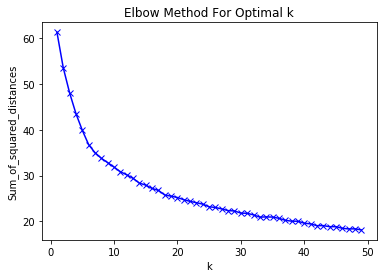

In [306]:
kmeans_optimize(df_kmeans)

We note that the elbow is just before k=10. To have a nice rounded number of clusters (interpretability, but enough variance between cities), we will pick k = 10.

In [307]:
k_pick = 10
clusters = KMeans(n_clusters=k_pick, random_state=0).fit(df_kmeans)

# add the cluster labels to the neighborhoods.
df_labeled = df_citiesEU_catfreq.copy()
df_labeled.insert(1, 'label', clusters.labels_)

df_labeled.head(10)

,City,label,Other,architecture,art_venue,coffeehouse,edu,fastfood,hotels_airports,nightlife,park,restaurant,scenic,shopping_venue,spa_relaxation,sport_venue,transport
0,A Coruna,8,0.1,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.4,0.2,0.1,0.0,0.0,0.0
1,Aachen,9,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.3,0.1,0.0,0.0
2,Aberdeen,5,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.6,0.1,0.1,0.0,0.0,0.0,0.0,0.0
3,Adana,2,0.0,0.1,0.1,0.1,0.0,0.1,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0
4,Adapazari,9,0.0,0.0,0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.0
5,Adiyaman,2,0.0,0.0,0.1,0.1,0.0,0.2,0.2,0.0,0.0,0.3,0.0,0.0,0.0,0.1,0.0
6,Albacete,8,0.0,0.0,0.0,0.2,0.0,0.0,0.1,0.1,0.1,0.4,0.0,0.1,0.0,0.0,0.0
7,Alcala de Henares,8,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.4,0.0,0.1,0.0,0.1,0.0
8,Alcorcon,6,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.1,0.0
9,Alicante,8,0.0,0.1,0.0,0.1,0.0,0.2,0.0,0.1,0.0,0.4,0.0,0.1,0.0,0.0,0.0


In [617]:
df_clustered = pd.merge(df_citiesEU_testframe, df_labeled, right_on='City', left_on='asciiname', how='right').drop(['asciiname'],axis=1)
df_clustered.head(10)

,latitude,longitude,City,label,Other,architecture,art_venue,coffeehouse,edu,fastfood,hotels_airports,nightlife,park,restaurant,scenic,shopping_venue,spa_relaxation,sport_venue,transport
0,41.01384,28.94966,Istanbul,4,0.02,0.18,0.24,0.06,0.00,0.06,0.10,0.08,0.00,0.02,0.00,0.10,0.04,0.08,0.02
1,55.75222,37.61556,Moscow,4,0.08,0.02,0.22,0.02,0.02,0.00,0.12,0.04,0.10,0.04,0.02,0.18,0.02,0.12,0.00
2,51.50853,-0.12574,London,4,0.02,0.02,0.22,0.02,0.00,0.02,0.12,0.14,0.06,0.12,0.00,0.24,0.02,0.00,0.00
3,59.93863,30.31413,Saint Petersburg,4,0.00,0.06,0.26,0.04,0.02,0.00,0.12,0.04,0.08,0.02,0.08,0.22,0.02,0.04,0.00
4,39.91987,32.85427,Ankara,4,0.04,0.04,0.38,0.04,0.00,0.04,0.00,0.10,0.04,0.10,0.00,0.12,0.00,0.10,0.00
5,52.52437,13.41053,Berlin,3,0.02,0.02,0.16,0.18,0.00,0.04,0.02,0.10,0.06,0.14,0.02,0.18,0.02,0.02,0.02
6,40.41650,-3.70256,Madrid,3,0.00,0.02,0.10,0.14,0.00,0.04,0.14,0.08,0.06,0.18,0.00,0.24,0.00,0.00,0.00
7,50.45466,30.52380,Kyiv,4,0.02,0.02,0.18,0.10,0.00,0.00,0.12,0.18,0.06,0.08,0.02,0.16,0.00,0.06,0.00
8,38.41273,27.13838,Izmir,3,0.08,0.04,0.18,0.18,0.00,0.00,0.04,0.04,0.02,0.08,0.02,0.26,0.00,0.06,0.00
9,41.89193,12.51133,Rome,4,0.00,0.22,0.12,0.10,0.00,0.14,0.04,0.02,0.06,0.06,0.02,0.22,0.00,0.00,0.00


## 4. Results / Discussion

In this section we will analyze the results of our clustering exercise. We will see if we can give meaningful descriptions to the different clusters - and visualize them on a map.

First we define a function to make visualizing the map easier.

In [555]:
def center_map(dataframe, lat, long, clusterno, legendvals):
    # create map
    map_create = folium.Map(location=[latitude, longitude], zoom_start=1)

        # set color scheme for the clusters
    x = np.arange(k_pick)
    ys = [i + x + (i*x)**2 for i in range(k_pick)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

        # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(dataframe['latitude'], dataframe['longitude'], dataframe['City'], dataframe['label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_create)

    # Creating legend
    for c in range(0,len(colors_array)):
        r=int(colors_array[c][0]*255)
        g=int(colors_array[c][1]*255)
        b=int(colors_array[c][2]*255)
        group = folium.FeatureGroup(name='<span style=\\"color:rgb({},{},{},{});\\">{}</span>'.format(r,g,b,1,str(c)+"-"+legendvals.iloc[c]['label']))
        group.add_to(map_create)


    folium.map.LayerControl('topright', collapsed=False).add_to(map_create)
        
    return map_create

### 4.1 Cluster Analysis

We now create plots of the different categories per cluster label to see what type of cities we have.

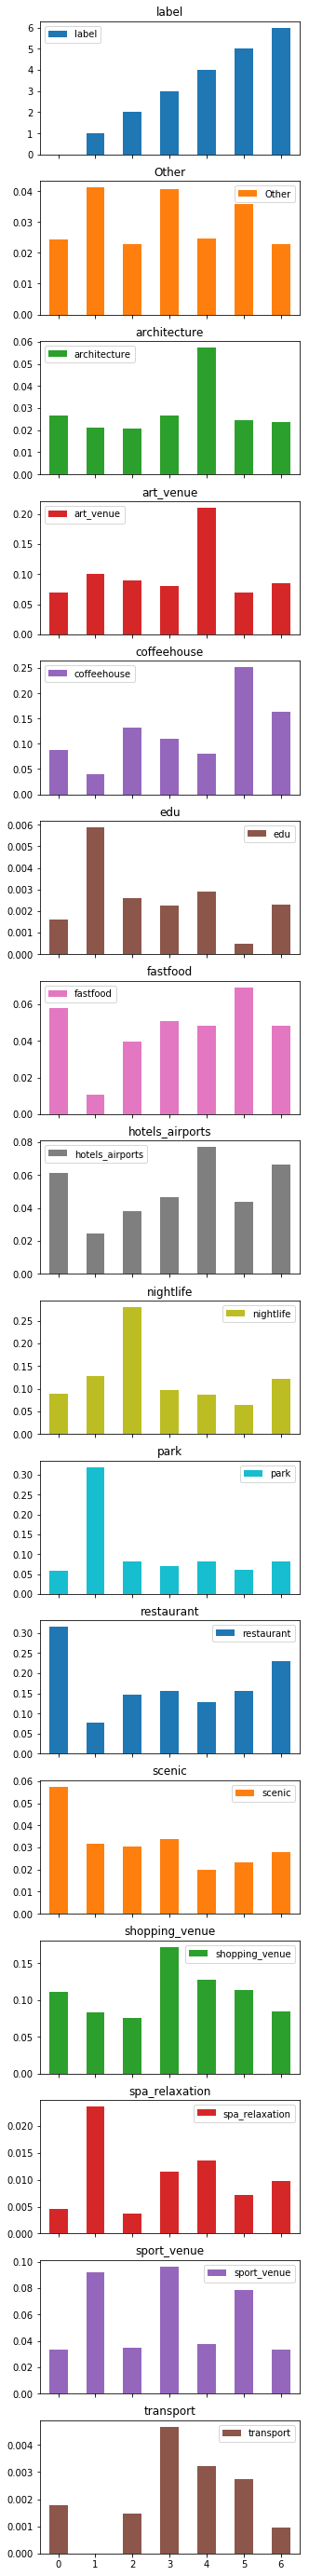

In [532]:
#define the mean of the category frequency per label:
df_clusteranalysis = df_clustered.groupby(['label']).mean().reset_index().drop(['latitude','longitude'],axis=1)
df_clusteranalysis

#create subplots of every label.
axes = df_clusteranalysis.plot.bar(rot=0, subplots=True, figsize=(5,50))

A single plot is given below. However - a comparison of values within each category is relatively difficult as categories with higher frequencies start taking the front stage.

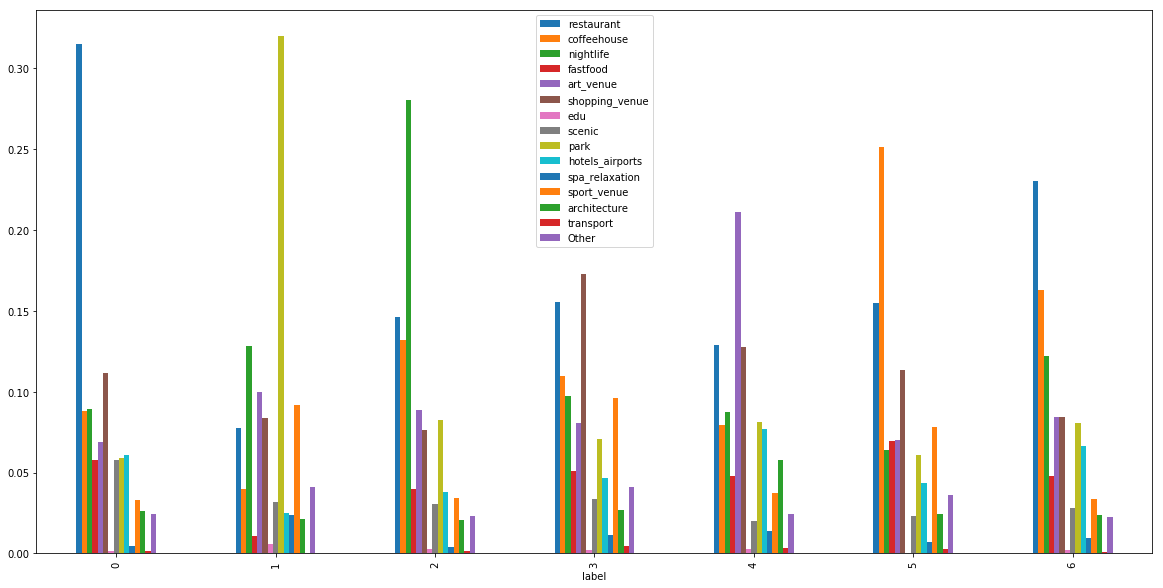

In [539]:
catcolumns = ['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']
axes2 = df_clusteranalysis.plot(kind='bar', x='label', y=catcolumns,figsize=(20,10))

Based on these graphs we can make sense of the clusters in the following way:
- Label 0: Food, scenic Views
- Label 1: Spa & Relaxation, Parks, Sports
- Label 2: Nightlife
- Label 3: Shopping, Scenic Views
- Label 4: Art, Culture, and Architecture
- Label 5: Brunch & Coffee, Dining and Shopping
- Label 6: Food, Dining and Nightlife

In [561]:
label_data = { 
        0: ' Food, and Scenic Views',
        1: ' Parks, Nightlife, Sports',
        2: ' Nightlife',
        3: ' Shopping, Scenic Views, Dining',
        4: ' Art, Culture, and Architecture',
        5: ' Brunch & Coffee, Dining and Shopping',
        6: ' Food, Dining and Nightlife'
             }

label_dataframe = pd.Series(label_data).to_frame(name='label')

Now, let's plot the cities on the map, differentiated by the different clusters

In [558]:
#Latitude and Longitude Values of Europe's Center
latitude_center = 48.499998
longitude_center = 23.3833318

center_map(dataframe=df_clustered,lat=latitude_center,long=longitude_center,clusterno=k_pick, legendvals=label_dataframe)

We can note some obvious distributions if we look at this map high over:
- A concentration of Parks, Nightlife and Sports (Label 1) in the UK.
- A concentration of Nightlife (Label 2) in Eastern Europe/Russia.
- A concentration of Art, Culture, Architecture (Label 4) in Greece, Turkey and Eastern Europe.
- A concentration or Brunch, Dining and Shopping (Label 5) in Central Europe.
- A concentration of Food, Dining and Nightlife (Label 6) in Southern Europe.

These clusters seem to be quite sensible. For example, warmer countries (especially beach destinations) are often used as destinations with lots of nightlife activities, together with many smaller restaurants that cater to tourists (i.e. label 6). Furthermore, the nightlife venues are very present in cities in eastern europe - often due to cheap booze.

### 4.2 Testing Recommendations based on User Preferences
Now, let's build a simple user profile. In practice, this could be done through a user interface that lets them select the preferences on the Venue_Categories. Here, we build a simple dataframe to test the recommendations.

Then based on the selected venue category importance, we create a weighted average of the ratings versus the frequency of a category in a city. Then we take the top 5 recommended cities and display these on a map.

First, we need to start training our labeled dataframe based on the previously provided labels. We define a function that tests a set of different algorithms using multiple scoring mechanisms. From that, we can select a fitting model to continue with.

In [656]:
def test_models(dataframe, X_features, Y_vars, scoring_mech, folds):
    X = dataframe[X_features]
    Y = dataframe[Y_vars].values.ravel()
    models = []
    models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
        # evaluate each model in turn
    results = []
    names = []
    scoring = scoring_mech
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "{}: Accuracy: {} Stdev: {}" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison '+scoring_mech)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
    return results

LR: Accuracy: 0.814000 Stdev: (0.095520)
KNN: Accuracy: 0.878000 Stdev: (0.065391)
CART: Accuracy: 0.806000 Stdev: (0.047371)
NB: Accuracy: 0.820000 Stdev: (0.048990)
SVM: Accuracy: 0.212000 Stdev: (0.058788)


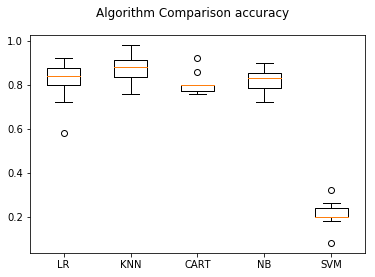

In [668]:
df_traintest = df_clustered.copy()
X = ['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']
Y = ['label']
test_scores = 'accuracy'

testresults = test_models(df_traintest, X_features=X, Y_vars=Y, scoring_mech=test_scores,folds=10)

Note that the performance of the KNN algorithm is best here, with an accuracy of 0.88. As such, we now properly train and test using this model. We will use a cross-fold validation as testing the different models above, and then optimize the model parameters using GridSearchCV.

In [664]:
#Define X, Y features/values.
X = df_clustered[['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']]
Y = df_clustered[['label']].values.ravel()

#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
params = {'n_neighbors': np.arange(1,25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, params, cv=10)

#fit the model to the X,Y values.
knn_gscv.fit(X,Y)

#check the best performing n_neighbors param
knn_gscv.best_params_

C:\Users\320042528\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 6}

It shows that the best n to pick for the KNN algorithm is 6. So we continue by training our model with n=6. First we check the accuracy using the cross-fold-validation with n_neighbors = 6. 

In [667]:
#Define X, Y features/values.
X = df_clustered[['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']]
Y = df_clustered[['label']].values.ravel()

#create new a knn model
knn = KNeighborsClassifier(n_neighbors=6)

#train model with CV = 10
cvpred = model_selection.cross_val_score(knn, X, Y, cv=10)
#print each cv score (accuracy) and average them
print('cvpred mean:{}, cvpred stdev:{}'.format(np.mean(cvpred), np.std(cvpred)))

cvpred mean:0.8948768311151571, cvpred stdev:0.03193561906722294


Using the gridsearch to pick the best n allowed us to increase accuracy with 1%, and decrease the standard deviation by a factor 2!

In [670]:
X = df_clustered[['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']]
Y = df_clustered[['label']].values.ravel()

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the data
knn.fit(X, Y)

#### 4.2.2. Defining a user profile and giving recommendations.
Now, let's use our prediction algorithm to give a recommendation to a generated user profile. First, we define a user profile by hand. We skew it especially towards shopping, restaurants and scenic venues to see if the prediction picks this up.

In [767]:
UserPref = pd.DataFrame([  
    {'Category':'Other', 'Preference': 1},
    {'Category':'architecture', 'Preference': 4},
    {'Category':'art_venue', 'Preference': 4},
    {'Category':'coffeehouse', 'Preference': 2},
    {'Category':'edu', 'Preference': 1},
    {'Category':'fastfood', 'Preference': 1},
    {'Category':'hotels_airports', 'Preference': 1},
    {'Category':'nightlife', 'Preference': 1},
    {'Category':'park', 'Preference': 1},
    {'Category':'restaurant','Preference': 4},
    {'Category':'scenic', 'Preference': 3},
    {'Category':'shopping_venue', 'Preference': 3},
    {'Category':'spa_relaxation', 'Preference': 1},
    {'Category':'sport_venue', 'Preference': 1},
    {'Category':'transport', 'Preference': 1},
])

UserPref['Preference'] = UserPref['Preference']/10
UserPref

,Category,Preference
0,Other,0.1
1,architecture,0.4
2,art_venue,0.4
3,coffeehouse,0.2
4,edu,0.1
5,fastfood,0.1
6,hotels_airports,0.1
7,nightlife,0.1
8,park,0.1
9,restaurant,0.4


In [768]:
def recommendation_city(UserProfile, cities):
    """
    make top n city recommendations
    """
    df_user = UserProfile.set_index('Category').transpose()
    X = df_user[['restaurant','coffeehouse','nightlife','fastfood','art_venue','shopping_venue','edu',
            'scenic','park','hotels_airports','spa_relaxation','sport_venue','architecture','transport','Other']]
    rec_label = int(knn.predict(X)[0])
    
    latitude_center = 48.499998
    longitude_center = 23.3833318
    isarec_city = cities['label'] == rec_label
    cities_rec = cities[isarec_city]
    createmap = center_map(dataframe=cities_rec,lat=latitude_center,long=longitude_center,clusterno=k_pick, legendvals=label_dataframe)
    return createmap

In [769]:
rec_label = recommendation_city(UserProfile = UserPref, cities=df_clustered)
rec_label

Indeed, it recommends us cities that, based on much visited venues, would be good for shopping, scenic views and dining!

## 5. Conclusion
It seems that, based on the popular venues and a custom generated venues within european cities, it is possible to recommend a handful of cities that would fit a certain user preference. 

Note however that, as the clustering was done on non-scaled features - creating a custom user profile based on user-defined inputs can be difficult. As such, one recommendation is to re-do modeling, except with min-max scaling to normalize the venue category frequencies to between 0 and 1. Another possibility to do this is too keep the clustering as is - but multiply the user preference (rated from 0 to 1) by the maximum value present in the category venue frequency to scale it down. However, we leave this as an exercise for a different time.

Moreover, some cities might be known for certain venues, but will not have them as recommended through the foursquare app. Additionally, many other factors can play a role in deciding what city might be fitting as a holiday destination, such as: costs of living/staying, temperature, seasonality, possible non-venue activities, culture, etc. Indeed, model improvements can likely be made by adding a different range of possible features. The clustering done here can either be used as an input for those models, or one can go back and still use the venue category frequency as features for different models.

In the end - we have shown here that cities shows similarities based on their top venues, and that it is possible to create recommendations through a user defined preference by clustering european cities. This project touches some key Data Science topics such as Business Case Definition, Data Sourcing/Cleaning & Wrangling, Data Modeling and Data Analysis. Nevertheless, significant improvements are possible, and this project should only be used as an inspiration or initial jump-off point to create a strong travel-recommendation engine.